# NYC Restaurant Recommendation

### Project Setup

In [2]:
#importing the Dependencies and Libraries 
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import difflib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

C:\Users\Phill\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
#importing the data
food = Path("C:/Users/Phill/OneDrive/Documents/Python Scripts/NY Restaurants data/ny.csv")
ny_data = pd.read_csv(food.resolve(), sep=',')

In [4]:
#first five rows of the dataset
ny_data.head()

,Title,Number of review,Catagory,Reveiw Comment,Popular food,Online Order
0,All Stars Sports Bar & Grill,21,"Bar, Pub","“The fries were terrific also, hot crisp...”",fries,Yes
1,Olio e Piu,"2,998","Italian, Pizza",“I love the food and our server Maria!”,filet mignon,Yes
2,Boucherie West Village,"1,465","French, Steakhouse",“The filet mignon was impeccable and the musse...,lobster,Yes
3,Club A Steakhouse,"4,413","American, Steakhouse",“My seafood cocktail had wonderful large lump ...,cacio e pepe,Yes
4,Piccola Cucina Estiatorio,403,"Italian, Sicilian",“penne al pomodoro and bucatini cacio e pepe w...,mussels,Yes


In [5]:
#number of rows and columns 
ny_data.shape

(10397, 6)

### Analysis and Preprocessing

In [6]:
#getting general info
ny_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10397 entries, 0 to 10396
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Title             10397 non-null  object
 1   Number of review  10397 non-null  object
 2   Catagory          10397 non-null  object
 3   Reveiw Comment    10397 non-null  object
 4   Popular food      10397 non-null  object
 5   Online Order      10397 non-null  object
dtypes: object(6)
memory usage: 487.5+ KB


In [7]:
#checking missing values
ny_data.isnull().sum()

Title               0
Number of review    0
Catagory            0
Reveiw Comment      0
Popular food        0
Online Order        0
dtype: int64

Looking over this information, it is hard to believe that there are no missing values, thus the entries must be explored further. Perhaps missing values were filled in with a placeholder values like n/a, no, or 0. 

In [8]:
#renaming columns for use
ny_data = ny_data.rename(columns={'Number of review': 'Reviews',
                        'Reveiw Comment': 'Comments',
                        'Catagory': 'Category',
                        'Popular food': 'Popular Food'})

ny_data.head(5)

,Title,Reviews,Category,Comments,Popular Food,Online Order
0,All Stars Sports Bar & Grill,21,"Bar, Pub","“The fries were terrific also, hot crisp...”",fries,Yes
1,Olio e Piu,"2,998","Italian, Pizza",“I love the food and our server Maria!”,filet mignon,Yes
2,Boucherie West Village,"1,465","French, Steakhouse",“The filet mignon was impeccable and the musse...,lobster,Yes
3,Club A Steakhouse,"4,413","American, Steakhouse",“My seafood cocktail had wonderful large lump ...,cacio e pepe,Yes
4,Piccola Cucina Estiatorio,403,"Italian, Sicilian",“penne al pomodoro and bucatini cacio e pepe w...,mussels,Yes


In [9]:
#checking values of columns with higher frequency entries
print(ny_data['Online Order'].value_counts())
print(' ')
print(ny_data['Popular Food'].value_counts())

Online Order
No            5729
Yes           4660
See events       7
Reserve          1
Name: count, dtype: int64
 
Popular Food
No                       7709
tuna                      129
ribeye                    127
Steak                      83
salad                      78
                         ... 
an Italian restaurant       1
Huevos rancheros            1
Great Mexican Food          1
Yorkshire pudding           1
soup dumplings              1
Name: count, Length: 539, dtype: int64


We can see that both columns contain extensive 'No' entries. I presume that this is in place of a null field. We will need to check this frequency with the Title, Category, and Comments columns as they are the most important for our analysis. 

In [10]:
#checking for No value for all columns within the dataframe
print (ny_data[ny_data == 'No'].count())

Title              7
Reviews         1511
Category           0
Comments        2199
Popular Food    7709
Online Order    5729
dtype: int64


In [11]:
#converting no values into null/NaN values
for column in ny_data.columns:
    ny_data[column].replace('No', np.nan, inplace=True)

ny_data.isnull().sum()

C:\Users\Phill\AppData\Local\Temp\ipykernel_23472\1547727016.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ny_data[column].replace('No', np.nan, inplace=True)


Title              7
Reviews         1511
Category           0
Comments        2199
Popular Food    7709
Online Order    5729
dtype: int64

<Axes: >

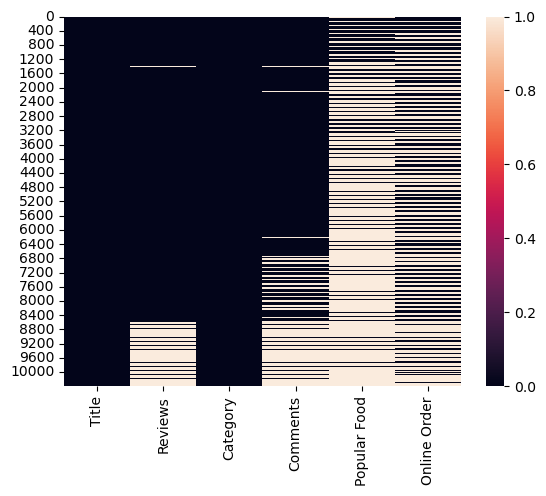

In [12]:
#checking the distribution of missing values 
sns.heatmap(ny_data.isnull())

This heatmap of missing values provides some interesting insights. Other than the Popular Food and Online Order column being littered with missing values we see that towards the bottom, many entries are missing both a Review and a Comment. While we are able to fill these missing values with empty text strings, it may not be beneficial to keep the entries that are missing both. Thus, we will remove entries are missing both a Review and Comment and then fill the remaining null fields so that they can be processed. 

In [13]:
#removing entries that do not contain a comment & review
bool_ny = (ny_data['Reviews'].isnull() & ny_data['Comments'].isnull())
ny_clean = ny_data[~bool_ny]
ny_clean.shape

(8886, 6)

Title              0
Reviews            0
Category           0
Comments         688
Popular Food    6198
Online Order    4340
dtype: int64


<Axes: >

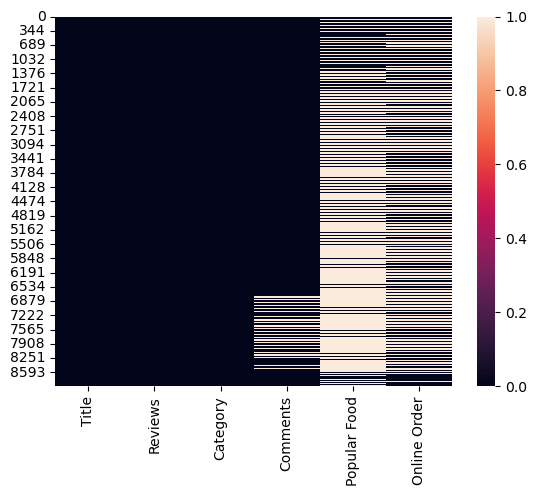

In [14]:
#Ensuring correct execution and reviewing the heatmap
print(ny_clean.isnull().sum())
sns.heatmap(ny_clean.isnull())

At first glance, it appeared that this approach did not work as intended. However, upon reviewing the new heatmap and missing values we see that Comments column is still missing 688 entries while the Reviews and Title columns went to 0, meaning that all of the entries missing the latter two, were also missing Comments. This has cleaned up a large portion of the data while still retaining a fair bit more entries than if we just removed all the rows missing data in these columns. 

In [15]:
#removing the Online Order Column
ny_clean = ny_clean.drop(columns='Online Order', axis=1)

In [16]:
ny_clean.head(-10)

,Title,Reviews,Category,Comments,Popular Food
0,All Stars Sports Bar & Grill,21,"Bar, Pub","“The fries were terrific also, hot crisp...”",fries
1,Olio e Piu,"2,998","Italian, Pizza",“I love the food and our server Maria!”,filet mignon
2,Boucherie West Village,"1,465","French, Steakhouse",“The filet mignon was impeccable and the musse...,lobster
3,Club A Steakhouse,"4,413","American, Steakhouse",“My seafood cocktail had wonderful large lump ...,cacio e pepe
4,Piccola Cucina Estiatorio,403,"Italian, Sicilian",“penne al pomodoro and bucatini cacio e pepe w...,mussels
...,...,...,...,...,...
10292,Momoya Soho,100,Indian,“Amazing!!!”,NaN
10323,Socarrat Paella Bar - Chelsea,225,"Seafood, Mediterranean",“We took the combined poultry and seafood pael...,seafood paella
10324,Tribeca Finest Marketplace,21,Chinese,"“The fries were terrific also, hot crisp...”",fries
10325,MrBeast Burger,207,"Bar, Pub",“Super dumplings!”,dumplings


This column was removed because it is missing half of its entries and was not going to be used for forming recommendations.  

In [17]:
#reset dataframe index
ny_clean = ny_clean.reset_index(drop=True)

In [18]:
#add index column
ny_clean['index'] = ny_clean.index

### Selecting Relevant Features for Recommendation

In [19]:
#list of features
selected_features = ['Title','Category','Comments', 'Popular Food']

In [20]:
#replacing the null values with null string
for feature in selected_features:
    ny_clean[feature] = ny_clean[feature].fillna('')

In [21]:
#combining all the 4 selected features 
combined_features = ny_clean['Title'] + ' ' + ny_clean['Category'] + ' ' + ny_clean['Comments'] + ' ' + ny_clean['Popular Food'] 

In [22]:
print(combined_features)

0       All Stars Sports Bar & Grill Bar, Pub “The fri...
1       Olio e Piu Italian, Pizza “I love the food and...
2       Boucherie West Village French, Steakhouse “The...
3       Club A Steakhouse American, Steakhouse “My sea...
4       Piccola Cucina Estiatorio Italian, Sicilian “p...
                              ...                        
8881    The Wing Dynasty American, Barbecue “We also h...
8882    The Wing Dynasty Chinese, Asian “We took the c...
8883    The Wing Dynasty Seafood, Mediterranean “We ha...
8884    The Wing Dynasty Italian, Romana “The lobster ...
8885    Balzem Steakhouse, Bar “Very Authentic & Delic...
Length: 8886, dtype: object


### Converting Text Data to Feature Vectors

In [23]:
#creating vectorizer
vectorizer = TfidfVectorizer()

In [24]:
feature_vectors = vectorizer.fit_transform(combined_features)

In [25]:
print(feature_vectors)

  (0, 1963)	0.3082085499929834
  (0, 3585)	0.2638716273647513
  (0, 337)	0.2590642465107629
  (0, 7491)	0.29485091775623734
  (0, 8189)	0.2183179979432711
  (0, 2976)	0.48784190205763517
  (0, 7521)	0.11577100601524284
  (0, 6044)	0.18439637266917416
  (0, 3280)	0.2071282067701654
  (0, 751)	0.2440556017280175
  (0, 7084)	0.2911193902423272
  (0, 7136)	0.30450127781075126
  (0, 318)	0.26140721184891236
  (1, 4861)	0.32196997222488255
  (1, 2784)	0.31764579420747185
  (1, 4636)	0.3765936519274606
  (1, 6706)	0.2651327057281084
  (1, 5460)	0.27949985692052715
  (1, 413)	0.11589111657266307
  (1, 2889)	0.13716666896197255
  (1, 4433)	0.25579329487550156
  (1, 5832)	0.12960829977344568
  (1, 3782)	0.12176338973278578
  (1, 5830)	0.4264371746033076
  (1, 5375)	0.4264371746033076
  :	:
  (8883, 4755)	0.15854221833350063
  (8883, 8167)	0.17243658510985677
  (8883, 8285)	0.2263938323092422
  (8883, 3349)	0.17159730674572835
  (8883, 6644)	0.16319765134118197
  (8883, 4377)	0.21966068034386196


### Cosine Similarity

In [26]:
#getting the similarity scores using cosine similarity 
similarity = cosine_similarity(feature_vectors)

In [27]:
print(similarity)

[[1.         0.01278762 0.12511872 ... 0.02549987 0.03149904 0.05797772]
 [0.01278762 1.         0.23695521 ... 0.03772038 0.06485502 0.        ]
 [0.12511872 0.23695521 1.         ... 0.11469962 0.17563854 0.04245106]
 ...
 [0.02549987 0.03772038 0.11469962 ... 1.         0.51304289 0.        ]
 [0.03149904 0.06485502 0.17563854 ... 0.51304289 1.         0.        ]
 [0.05797772 0.         0.04245106 ... 0.         0.         1.        ]]


In [28]:
print(similarity.shape)

(8886, 8886)


In [29]:
#getting the restaurant from the user
restaurant_name = input('Enter your favorite Restaurant in NYC : ')

Enter your favorite Restaurant in NYC : Stage Door Deli


In [30]:
list_of_names = ny_clean['Title'].tolist()

In [31]:
print(list_of_names)

['All Stars Sports Bar & Grill', 'Olio e Piu', 'Boucherie West Village', 'Club A Steakhouse', 'Piccola Cucina Estiatorio', 'Boucherie Union Square', 'KOBA Korean Bbq', 'Katherine', 'Bleecker Street Pizza', 'Numero 28 Pizzeria', 'SottoCasa Pizzeria', 'Los Tacos No. 1', 'Quality Bistro', 'The Consulate', 'Petite Boucherie', 'Spice Symphony', 'Mei Jin Ramen', 'Bua Thai Ramen & Robata Grill', 'Famous Amadeus Pizza', 'Bagels & Schmear', 'Piccola Cucina Osteria', 'Loi Estiatorio', 'La Grande Boucherie', 'K Rico Steakhouse', 'Lezzet Mediterranean Turkish Restaurant', 'Jungsik', 'Pure Thai Cookhouse', 'Spice Symphony', 'Scalini Fedeli', 'Kuu Ramen', 'Tangy Noodle', "Bill's Bar & Burger", 'Royal 35 Steakhouse', "Patsy's Italian Restaurant", "Bill's Bar & Burger", 'Jams, 6th Avenue, New York, NY, USA', 'Benjamin Steakhouse', 'Benjamin Steakhouse', 'IL Punto Ristorante', 'San Carlo Osteria Piemonte', 'B Side Pizzeria', 'Dos Caminos', 'NY Pizza Suprema', 'Balzem', 'Buenos Aires', 'Daniel', 'Craft'

In [32]:
#finding the close match for restaurant name provided by the user
close_match = difflib.get_close_matches(restaurant_name, list_of_names)
print(close_match)

['Stage Door Deli', 'Stage Star Deli', 'Seaport Deli']


In [33]:
match = close_match[0]

In [34]:
#finding the index of the restaurant with name
index_of_name = ny_clean[ny_clean.Title == match]['index'].values[0]
print(index_of_name)

162


In [35]:
#getting a list of similar restaurants 
sim_score = list(enumerate(similarity[index_of_name]))
print(sim_score)

[(0, 0.0), (1, 0.021481000761975115), (2, 0.0), (3, 0.011364035851303841), (4, 0.0), (5, 0.021551563113211013), (6, 0.0), (7, 0.07142012888210568), (8, 0.041636510709888934), (9, 0.04309926652452665), (10, 0.04823544120172236), (11, 0.0), (12, 0.01563419195730714), (13, 0.011957538929991846), (14, 0.0), (15, 0.0), (16, 0.0), (17, 0.0), (18, 0.026685978246114083), (19, 0.11632469908002084), (20, 0.0), (21, 0.0), (22, 0.0), (23, 0.010267430004488967), (24, 0.0), (25, 0.0), (26, 0.0), (27, 0.0), (28, 0.0), (29, 0.0), (30, 0.0), (31, 0.015399694423493766), (32, 0.019639624328374326), (33, 0.0), (34, 0.01951139953909156), (35, 0.04877190552310267), (36, 0.0), (37, 0.0), (38, 0.0), (39, 0.0), (40, 0.038355591983349674), (41, 0.0), (42, 0.04974638319509258), (43, 0.0), (44, 0.04343232112977704), (45, 0.0), (46, 0.12209792867705141), (47, 0.021833827263285022), (48, 0.03174618021353835), (49, 0.012838459518197131), (50, 0.010472542180748091), (51, 0.013045932630519043), (52, 0.0), (53, 0.01254

In [36]:
#sorting the restaurants on their similarity scores 
sorted_sim = sorted(sim_score, key = lambda x:x[1], reverse = True)
print(sorted_sim)

[(162, 1.0000000000000004), (1739, 0.3075121207404926), (2743, 0.3031066592793137), (5121, 0.29008295957191876), (7129, 0.27139777521425773), (4782, 0.26273231864782953), (3723, 0.2625552475903321), (2354, 0.2559599825463609), (4449, 0.2559599825463609), (8171, 0.2559599825463609), (8680, 0.2559599825463609), (1050, 0.25257518738896273), (183, 0.25065783443457657), (1066, 0.25065783443457657), (2649, 0.25065783443457657), (7343, 0.24877489355613375), (445, 0.24716369334337362), (2466, 0.2425959755934281), (103, 0.24030081982710966), (1348, 0.24030081982710966), (1935, 0.24030081982710966), (2464, 0.24030081982710966), (2981, 0.24030081982710966), (3444, 0.24030081982710966), (3714, 0.24030081982710966), (4681, 0.24030081982710966), (4926, 0.24030081982710966), (5147, 0.24030081982710966), (6586, 0.24030081982710966), (6623, 0.24030081982710966), (547, 0.2389250193612718), (4557, 0.2387534852996278), (6736, 0.23130150116331613), (8114, 0.23112400662625615), (5288, 0.22645532462142415), 

In [37]:
#print similar restaurants based on index
print('Restaurants suggestions: \n')

i = 1

for r in sorted_sim:
    index = r[0]
    title_index = ny_clean[ny_clean.index==index]['Title'].values[0]
    if (title_index!=restaurant_name):
        if (i<10):
            print(i, '.', title_index)
            i+=1

Restaurants suggestions: 

1 . Delmonico NYC
2 . Stage Star Deli
3 . H&H Bagels
4 . Catherine's Deli And Bagels
5 . Black Door
6 . Black Seed Bagels
7 . Rico Bagel
8 . Rico Bagel
9 . Rico Bagel


### NYC Restaurant Recommendation System

In [43]:
#complete system
restaurant_name = input('Enter your favorite Restaurant in NYC : ')

list_of_names = ny_clean['Title'].tolist()

close_match = difflib.get_close_matches(restaurant_name, list_of_names)

match = close_match[0]

index_of_name = ny_clean[ny_clean.Title == match]['index'].values[0]

sim_score = list(enumerate(similarity[index_of_name]))

sorted_sim = sorted(sim_score, key = lambda x:x[1], reverse = True)

print('Restaurants suggestions: \n')

i = 1

for r in sorted_sim:
    index = r[0]
    title_index = ny_clean[ny_clean.index==index]['Title'].values[0]
    if (title_index!=restaurant_name):
        if (i<11):
            print(i, '.', title_index)
            i+=1

Enter your favorite Restaurant in NYC : Surya
Restaurants suggestions: 

1 . Taste Good Restaurant
2 . Brick Lane Curry House
3 . Benares Indian Restaurant
4 . Indian King Biryani House
5 . Polash Indian Restaurant
6 . Le Monde
7 . Bengal Tiger Indian Food
8 . Jean Claude 2
9 . Lezzet Mediterranean Turkish Restaurant
10 . Poulette
